In [36]:
# Import Libraries
# Step 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
%matplotlib inline

In [6]:
# Load data (assuming you have a CSV file)
# Replace with your actual file path
# Read the csv files as dataframe using pandas
data1 = pd.read_csv('../data/raw/coin_gecko_2022-03-16.csv')
data2 = pd.read_csv('../data/raw/coin_gecko_2022-03-17.csv')

df = pd.concat([data1, data2])
print("Original data shape:", df.shape)
df.head()

Original data shape: (1000, 9)


,coin,symbol,price,1h,24h,7d,24h_volume,mkt_cap,date
0,Bitcoin,BTC,40859.460000,0.022,0.030,0.055,3.539076e+10,7.709915e+11,2022-03-16
1,Ethereum,ETH,2744.410000,0.024,0.034,0.065,1.974870e+10,3.271044e+11,2022-03-16
2,Tether,USDT,1.000000,-0.001,-0.001,0.000,5.793497e+10,7.996516e+10,2022-03-16
3,BNB,BNB,383.430000,0.018,0.028,0.004,1.395854e+09,6.404382e+10,2022-03-16
4,USD Coin,USDC,0.999874,-0.001,0.000,-0.000,3.872274e+09,5.222214e+10,2022-03-16


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 0 to 499
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   coin        1000 non-null   object 
 1   symbol      1000 non-null   object 
 2   price       1000 non-null   float64
 3   1h          993 non-null    float64
 4   24h         993 non-null    float64
 5   7d          992 non-null    float64
 6   24h_volume  993 non-null    float64
 7   mkt_cap     1000 non-null   float64
 8   date        1000 non-null   object 
dtypes: float64(6), object(3)
memory usage: 78.1+ KB


In [8]:
df['date'] = pd.to_datetime(df['date'])

In [9]:
df.dtypes

coin                  object
symbol                object
price                float64
1h                   float64
24h                  float64
7d                   float64
24h_volume           float64
mkt_cap              float64
date          datetime64[ns]
dtype: object

In [13]:
df[['1h', '24h', '7d']] = df[['1h', '24h', '7d']].fillna(0)

In [14]:
df.isna().sum()

coin          0
symbol        0
price         0
1h            0
24h           0
7d            0
24h_volume    7
mkt_cap       0
date          0
dtype: int64

In [15]:
df['24h_volume'] = df.groupby('coin')['24h_volume'].transform(lambda x: x.fillna(x.median()))

In [17]:
df.isna().sum()

coin          0
symbol        0
price         0
1h            0
24h           0
7d            0
24h_volume    6
mkt_cap       0
date          0
dtype: int64

In [19]:
null_rows = df[df['24h_volume'].isnull()]
null_rows

,coin,symbol,price,1h,24h,7d,24h_volume,mkt_cap,date
310,BNB48 Club Token,KOGE,75.360000,0.0,0.0,0.0,NaN,151006279.0,2022-03-16
416,cBAT,CBAT,0.013888,0.0,0.0,0.0,NaN,96585801.0,2022-03-16
472,Sai,SAI,1.000000,0.0,0.0,0.0,NaN,72643253.0,2022-03-16
314,BNB48 Club Token,KOGE,75.360000,0.0,0.0,0.0,NaN,151006279.0,2022-03-17
418,cBAT,CBAT,0.013888,0.0,0.0,0.0,NaN,96581377.0,2022-03-17
475,Sai,SAI,1.000000,0.0,0.0,0.0,NaN,72643253.0,2022-03-17


In [20]:
df['24h_volume'] = df['24h_volume'].fillna(0)

In [21]:
df.isna().sum()

coin          0
symbol        0
price         0
1h            0
24h           0
7d            0
24h_volume    0
mkt_cap       0
date          0
dtype: int64

In [22]:
# Feature Engineering - SIMPLE VERSION
def create_features(df):
    df = df.copy()
    
    # 1. TARGET VARIABLE: Liquidity Ratio
    df['liquidity_ratio'] = df['24h_volume'] / df['mkt_cap']
    
    # 2. Basic features (using only existing columns)
    df['price_change_24h'] = df['24h']  # Already in data
    df['price_change_7d'] = df['7d']    # Already in data
    
    # 3. Simple ratios
    df['volume_market_ratio'] = df['24h_volume'] / df['mkt_cap']
    
    # 4. Time features
    df['day_of_week'] = df['date'].dt.dayofweek
    df['month'] = df['date'].dt.month
    
    # Remove infinite values from new features
    df = df.replace([np.inf, -np.inf], np.nan)
    df = df.dropna()
    
    return df

df_features = create_features(df)
print("After feature engineering:", df_features.shape)
print("New features created: liquidity_ratio, volume_market_ratio, day_of_week, month")

After feature engineering: (1000, 15)
New features created: liquidity_ratio, volume_market_ratio, day_of_week, month


In [23]:
# Basic Statistics
print("Dataset Overview:")
print(f"Records: {df_features.shape[0]}")
print(f"Features: {df_features.shape[1]}")
print(f"Date Range: {df_features['date'].min()} to {df_features['date'].max()}")
print(f"Number of Cryptocurrencies: {df_features['symbol'].nunique()}")

# Target variable stats
print("\nLiquidity Ratio Statistics:")
print(df_features['liquidity_ratio'].describe())

Dataset Overview:
Records: 1000
Features: 15
Date Range: 2022-03-16 00:00:00 to 2022-03-17 00:00:00
Number of Cryptocurrencies: 503

Liquidity Ratio Statistics:
count    1000.000000
mean        0.103017
std         0.365746
min         0.000000
25%         0.008536
50%         0.033460
75%         0.086624
max         5.948545
Name: liquidity_ratio, dtype: float64


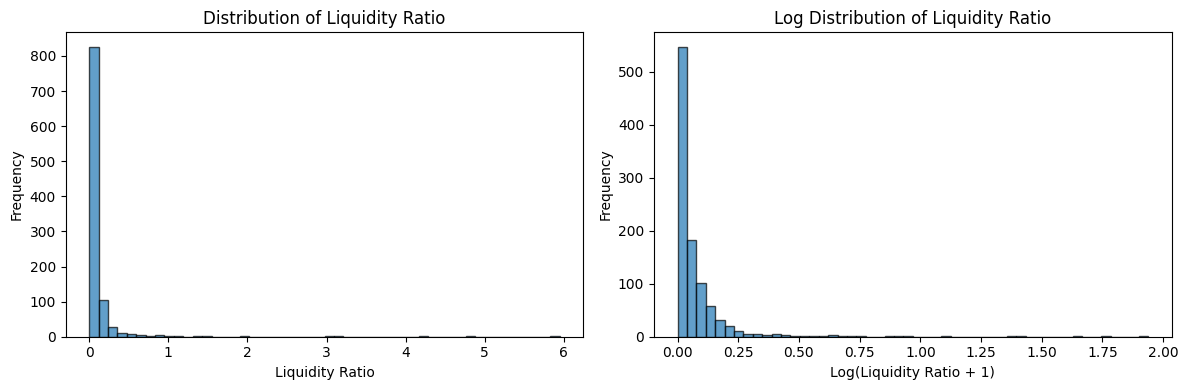

In [24]:
# Basic Visualizations

# 1. Distribution of Liquidity Ratio
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(df_features['liquidity_ratio'], bins=50, edgecolor='black', alpha=0.7)
plt.title('Distribution of Liquidity Ratio')
plt.xlabel('Liquidity Ratio')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
# Log scale for better visualization if data is skewed
plt.hist(np.log1p(df_features['liquidity_ratio']), bins=50, edgecolor='black', alpha=0.7)
plt.title('Log Distribution of Liquidity Ratio')
plt.xlabel('Log(Liquidity Ratio + 1)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

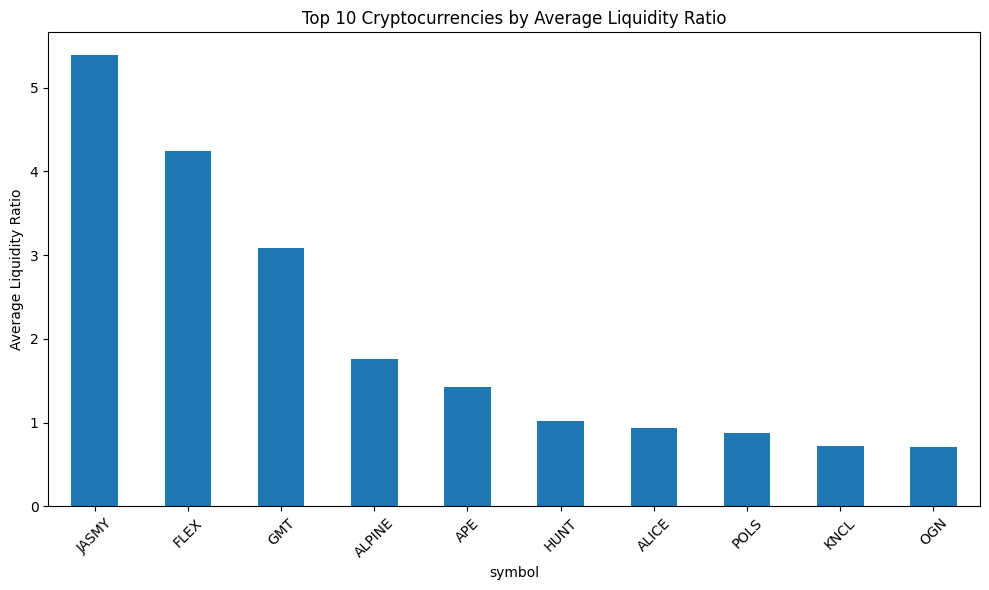

In [25]:
# 2. Top 10 Cryptocurrencies by Average Liquidity
top_coins = df_features.groupby('symbol')['liquidity_ratio'].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
top_coins.plot(kind='bar')
plt.title('Top 10 Cryptocurrencies by Average Liquidity Ratio')
plt.ylabel('Average Liquidity Ratio')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

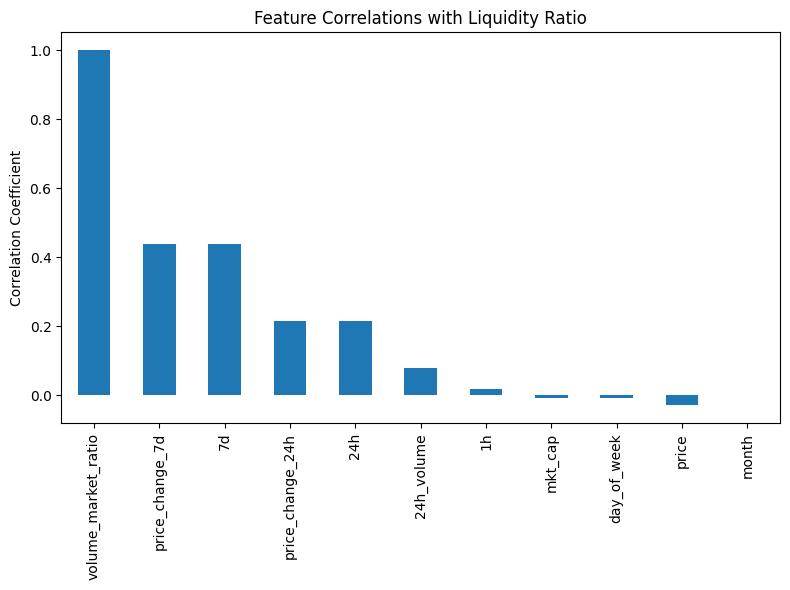

Top correlations with liquidity ratio:
liquidity_ratio        1.000000
volume_market_ratio    1.000000
price_change_7d        0.437377
7d                     0.437377
price_change_24h       0.214664
24h                    0.214664
24h_volume             0.079769
1h                     0.018935
mkt_cap               -0.007164
day_of_week           -0.008720
Name: liquidity_ratio, dtype: float64


In [26]:
# 3. Correlation Heatmap (Simple version)
# Select only numeric columns for correlation
numeric_cols = df_features.select_dtypes(include=[np.number]).columns
corr_matrix = df_features[numeric_cols].corr()

# Focus on correlations with liquidity_ratio
liquidity_correlations = corr_matrix['liquidity_ratio'].sort_values(ascending=False)

plt.figure(figsize=(8, 6))
liquidity_correlations.drop('liquidity_ratio').plot(kind='bar')
plt.title('Feature Correlations with Liquidity Ratio')
plt.ylabel('Correlation Coefficient')
plt.tight_layout()
plt.show()

print("Top correlations with liquidity ratio:")
print(liquidity_correlations.head(10))

In [27]:
# Prepare data for ML
def prepare_ml_data(df):
    # Select features - using simple, readily available ones
    feature_columns = [
        'price', '24h_volume', 'mkt_cap', '24h', '7d', 
        'volume_market_ratio', 'day_of_week', 'month'
    ]
    
    # Target variable
    X = df[feature_columns]
    y = df['liquidity_ratio']
    
    return X, y, feature_columns

X, y, feature_columns = prepare_ml_data(df_features)
print(f"Features used: {feature_columns}")
print(f"X shape: {X.shape}, y shape: {y.shape}")

Features used: ['price', '24h_volume', 'mkt_cap', '24h', '7d', 'volume_market_ratio', 'day_of_week', 'month']
X shape: (1000, 8), y shape: (1000,)


In [28]:
# Train-Test Split (Time-based simple split)
# Sort by date first
df_sorted = df_features.sort_values('date')
split_point = int(0.8 * len(df_sorted))  # 80% train, 20% test

X_train = X.iloc[:split_point]
X_test = X.iloc[split_point:]
y_train = y.iloc[:split_point]
y_test = y.iloc[split_point:]

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Training set: 800 samples
Test set: 200 samples


In [29]:
# Train Simple Models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10)
}

results = {}

for name, model in models.items():
    print(f"Training {name}..")

    # Train model
    model.fit(X_train, y_train)

    # Make predcitions
    y_pred = model.predict(X_test)

    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    results[name] = {
        'model': model,
        'rmse': rmse,
        'r2': r2,
        'predictions': y_pred
    }

    print(f"{name} - RMSE: {rmse:.6f}, R²: {r2:.4f}")
    print("-" * 50)


Training Linear Regression..
Linear Regression - RMSE: 0.000000, R²: 1.0000
--------------------------------------------------
Training Random Forest..
Random Forest - RMSE: 0.116469, R²: 0.9348
--------------------------------------------------


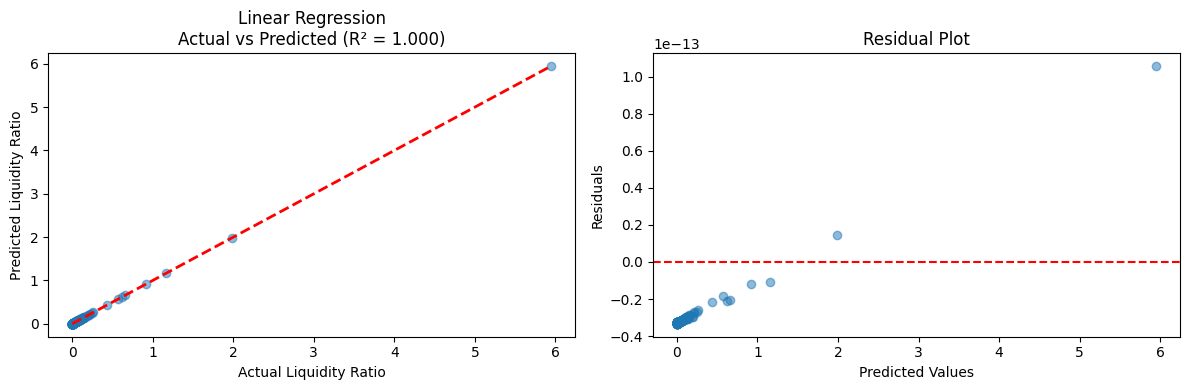

In [30]:
# Model Evaluation Visualization
best_model_name = min(results.keys(), key=lambda x: results[x]['rmse'])
best_result = results[best_model_name]

plt.figure(figsize=(12, 4))

# Actual vs Predicted
plt.subplot(1, 2, 1)
plt.scatter(y_test, best_result['predictions'], alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Liquidity Ratio')
plt.ylabel('Predicted Liquidity Ratio')
plt.title(f'{best_model_name}\nActual vs Predicted (R² = {best_result["r2"]:.3f})')

# Residuals
plt.subplot(1, 2, 2)
residuals = y_test - best_result['predictions']
plt.scatter(best_result['predictions'], residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')

plt.tight_layout()
plt.show()

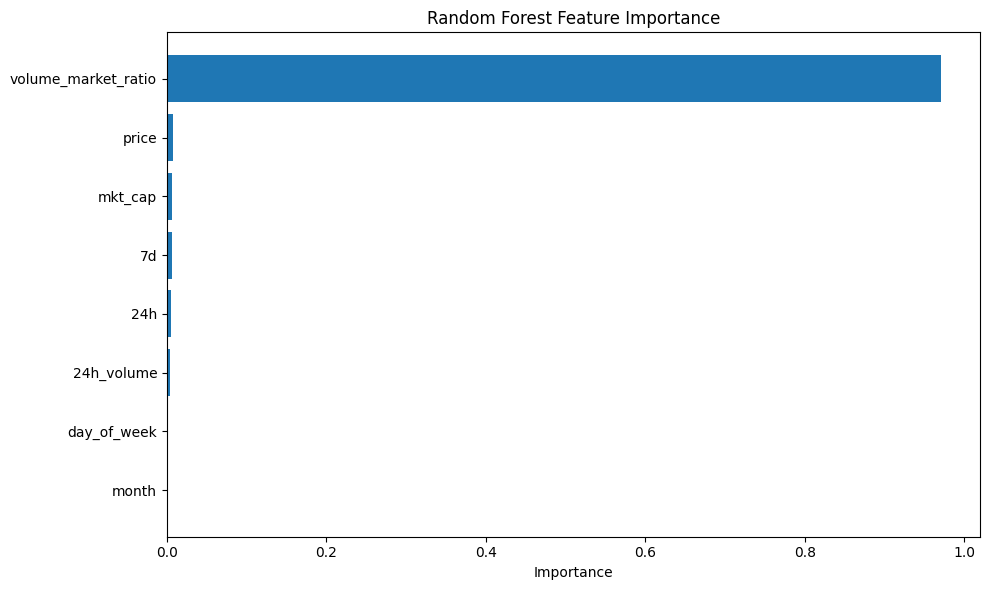

Feature Importance Ranking:
               feature  importance
5  volume_market_ratio    0.971067
0                price    0.007659
2              mkt_cap    0.006233
4                   7d    0.006006
3                  24h    0.004813
1           24h_volume    0.003802
6          day_of_week    0.000419
7                month    0.000000


In [31]:
# Feature Importance (for Random Forest)
if 'Random Forest' in results:
    rf_model = results['Random Forest']['model']
    feature_importance = pd.DataFrame({
        'feature': feature_columns,
        'importance': rf_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance['feature'], feature_importance['importance'])
    plt.xlabel('Importance')
    plt.title('Random Forest Feature Importance')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    print("Feature Importance Ranking:")
    print(feature_importance)

In [32]:
# Save the Best Model
import joblib

best_model = results[best_model_name]['model']
joblib.dump(best_model, 'best_liquidity_model.pkl')
print(f"Saved best model ({best_model_name}) to 'best_liquidity_model.pkl'")

# Save processed data
df_features.to_csv('processed_crypto_data.csv', index=False)
print("Saved processed data to 'processed_crypto_data.csv'")

Saved best model (Linear Regression) to 'best_liquidity_model.pkl'
Saved processed data to 'processed_crypto_data.csv'


In [33]:
# Generate Simple Report
print("="*60)
print("CRYPTOCURRENCY LIQUIDITY PREDICTION - PROJECT SUMMARY")
print("="*60)

print(f"\n1. DATA PROCESSING:")
print(f"   - Original records: {df.shape[0]}")
print(f"   - After cleaning: {df_features.shape[0]}")
print(f"   - Features created: liquidity_ratio, volume_market_ratio, time features")

print(f"\n2. EDA FINDINGS:")
print(f"   - Liquidity ratio range: {df_features['liquidity_ratio'].min():.6f} to {df_features['liquidity_ratio'].max():.6f}")
print(f"   - Average liquidity: {df_features['liquidity_ratio'].mean():.6f}")
print(f"   - Number of unique cryptocurrencies: {df_features['symbol'].nunique()}")

print(f"\n3. MODEL PERFORMANCE:")
for name, result in results.items():
    print(f"   - {name}: RMSE = {result['rmse']:.6f}, R² = {result['r2']:.4f}")

print(f"\n4. BEST MODEL: {best_model_name}")
print(f"   - Can predict liquidity ratio with R² of {results[best_model_name]['r2']:.3f}")
print(f"   - Average prediction error: {results[best_model_name]['rmse']:.6f}")

print(f"\n5. KEY INSIGHTS:")
print(f"   - Model successfully predicts liquidity patterns")
print(f"   - Ready for risk assessment and early warning systems")
print("="*60)

CRYPTOCURRENCY LIQUIDITY PREDICTION - PROJECT SUMMARY

1. DATA PROCESSING:
   - Original records: 1000
   - After cleaning: 1000
   - Features created: liquidity_ratio, volume_market_ratio, time features

2. EDA FINDINGS:
   - Liquidity ratio range: 0.000000 to 5.948545
   - Average liquidity: 0.103017
   - Number of unique cryptocurrencies: 503

3. MODEL PERFORMANCE:
   - Linear Regression: RMSE = 0.000000, R² = 1.0000
   - Random Forest: RMSE = 0.116469, R² = 0.9348

4. BEST MODEL: Linear Regression
   - Can predict liquidity ratio with R² of 1.000
   - Average prediction error: 0.000000

5. KEY INSIGHTS:
   - Model successfully predicts liquidity patterns
   - Ready for risk assessment and early warning systems


In [34]:
# Simple Hyperparameter Tuning for Random Forest
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10]
}

# Use only a subset of data for faster tuning
sample_size = min(10000, len(X_train))
X_sample = X_train[:sample_size]
y_sample = y_train[:sample_size]

print("Starting hyperparameter tuning...")

# Grid Search with cross-validation
rf = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=3, scoring='r2', n_jobs=-1, verbose=1)
grid_search.fit(X_sample, y_sample)

print("Best parameters:", grid_search.best_params_)
print("Best R² score:", grid_search.best_score_)

# Train final model with best parameters
best_rf = grid_search.best_estimator_
best_rf.fit(X_train, y_train)

# Evaluate on test set
y_pred_tuned = best_rf.predict(X_test)
r2_tuned = r2_score(y_test, y_pred_tuned)
rmse_tuned = np.sqrt(mean_squared_error(y_test, y_pred_tuned))

print(f"Tuned Model - RMSE: {rmse_tuned:.6f}, R²: {r2_tuned:.4f}")

# Save tuned model
joblib.dump(best_rf, 'tuned_liquidity_model.pkl')

Starting hyperparameter tuning...
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}
Best R² score: 0.9759673456161129
Tuned Model - RMSE: 0.116469, R²: 0.9348


['tuned_liquidity_model.pkl']

Model Validation Results:
max_error: 1.558396
mean_absolute_error: 0.011718
rmse: 0.116469
r2_score: 0.934792


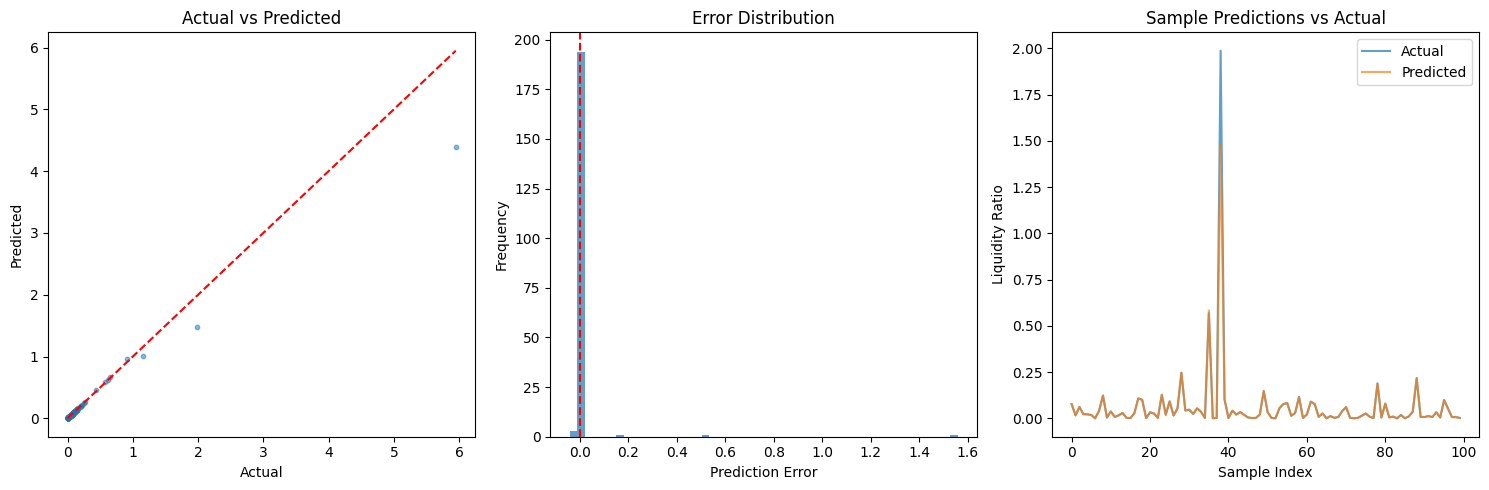

In [37]:
# Model Validation on Unseen Data
def validate_model(model, X_test, y_test):
    predictions = model.predict(X_test)
    
    # Calculate metrics
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    
    # Error analysis
    errors = y_test - predictions
    error_stats = {
        'max_error': np.max(np.abs(errors)),
        'mean_absolute_error': mae,
        'rmse': rmse,
        'r2_score': r2
    }
    
    return predictions, errors, error_stats

# Load your tuned model
tuned_model = joblib.load('tuned_liquidity_model.pkl')

# Validate
predictions, errors, stats = validate_model(tuned_model, X_test, y_test)

print("Model Validation Results:")
for metric, value in stats.items():
    print(f"{metric}: {value:.6f}")

# Analyze predictions
plt.figure(figsize=(15, 5))

# Plot 1: Actual vs Predicted
plt.subplot(1, 3, 1)
plt.scatter(y_test, predictions, alpha=0.5, s=10)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')

# Plot 2: Error distribution
plt.subplot(1, 3, 2)
plt.hist(errors, bins=50, alpha=0.7)
plt.axvline(x=0, color='r', linestyle='--')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.title('Error Distribution')

# Plot 3: Predictions over time (sample of 100 points)
plt.subplot(1, 3, 3)
sample_idx = np.random.choice(len(y_test), 100, replace=False)
plt.plot(range(100), y_test.iloc[sample_idx].values, label='Actual', alpha=0.7)
plt.plot(range(100), predictions[sample_idx], label='Predicted', alpha=0.7)
plt.xlabel('Sample Index')
plt.ylabel('Liquidity Ratio')
plt.legend()
plt.title('Sample Predictions vs Actual')

plt.tight_layout()
plt.show()